# Tutorial : Download ERA5 precipitation data and run snowslide

For initializing the algorithm, a first order estimation of precipitations can be derived from ERA5 weather datasets. The advantage of using these data is that they are available on a global scale and can be easily accessed through the API services of the Copernicus Climate Change Service. In the 'preprocess_data.py file', we propose a set of routines designed in particular to download and preprocess ERA5 data to adapt it to the needs of the initialization algorithm. 

This work refers to the dataset : "Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Horányi, A., Muñoz Sabater, J., Nicolas, J., Peubey, C., Radu, R., Rozum, I., Schepers, D., Simmons, A., Soci, C., Dee, D., Thépaut, J-N. (2023): ERA5 hourly data on single levels from 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), DOI: 10.24381/cds.adbb2d47"

The aim of this notebook is to explain the automated procedure for :
- (1) - Downloading ERA5 climate data from C3S
- (2) - Initializing initial snow height matrices from this data in order
- (3) - Running the algorithm on a chosen digital terrain model with the preprocessed weather data

<font color='red'> Warning : <font color='white'>You need to install the cdsapi module before running this notebook. The package can be installed trough the ``$ pip install cdsapi`` command on the terminal.

In [1]:
# Importations
import os
import snowslide
import xarray as xr

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
os.chdir("/Users/llemcf/Desktop/Stage_IGE_2023/GitHub_snowslide/snowslide/example") # needs modification by user

### 1) Downloading weather data from C3S
First let's download the weather data used to initalize precipitations. A fonction that automatize this routine can be found in the preprocess_data.py file and using the download_ERA5_data function. The user must specify at least the inputs : 
- start_date
- end_date 
- area

By default, ['2m_temperature','geopotential','total_precipitation'] are the variable that will be downloaded from the 'reanalysis-era5-single-levels'. 
The downloading is based on the cdsapi python module needed to download the data from Copernicus data center. You need to install the cdsapi module before running this notebook. The package can be installed trough the $ pip install cdsapi command on the terminal.

In [ ]:
# Importing function 
from snowslide.preprocess_data import download_ERA5_data

# Let's download the data over specified period and localisation
start_date = '2020-01-01'
end_date = '2020-03-31'
dem_path = "data/dem.tif"
download_ERA5_data(start_date,end_date,dem_path)

<font color='red'> Apparemment il y a une nouvelle version du CDS app donc c'est la raison pour laquelle ça ne fonctionne pas.

Then the netcdf dataset can be opened with the python xarray package.

In [17]:
ds_path = "tutorials/download_era5_data.nc"
ds = xr.open_dataset(ds_path)
ds

<xarray.Dataset>
Dimensions:    (longitude: 5, latitude: 5, time: 2184)
Coordinates:
  * longitude  (longitude) float32 5.0 5.25 5.5 5.75 6.0
  * latitude   (latitude) float32 44.0 43.75 43.5 43.25 43.0
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-03-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-12 11:45:16 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### 2) Initializing snow height matrices 
The structure shows that the variables are arranged in the form of arrays indexed by time (every hour), latitude and longitude. However, in order to initialise the algorithm with snow heights, it needs to be given a series of input arrays, generally with a frequency greater than hourly (e.g. monthly). Snowslide offers a function to pre-process this netcdf data and transform it into a list of snow height initialisation matrices according to the frequency chosen by the user. 

In [8]:
from snowslide.preprocess_data import initilialize_snowslide_from_era5
time,prcpt = initilialize_snowslide_from_era5(dem_path,ds_path,frequency="M",snow_d=200)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/llemcf/Desktop/Stage_IGE_2023/GitHub_snowslide/snowslide/snowslide/preprocess_data.py:34: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(in_proj, out_proj, x, y)


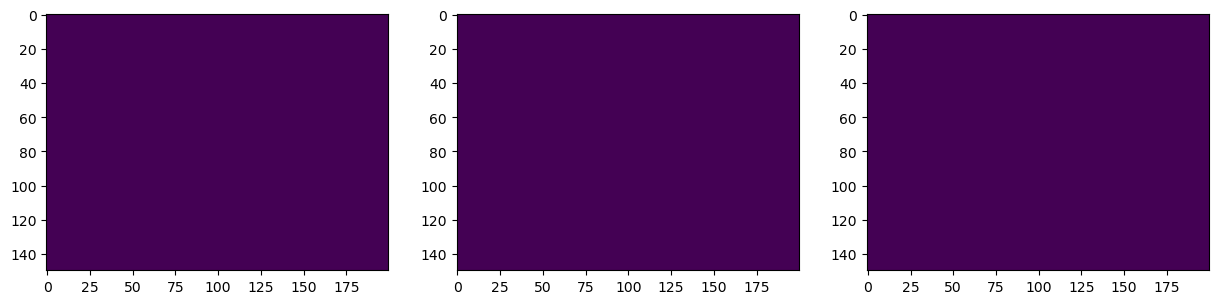

In [9]:
# Plotting code 
import matplotlib.pyplot as plt 
fig,ax = plt.subplots(1,len(prcpt),figsize=(15,4))
for i in range(len(prcpt)) :
    ax[i].imshow(prcpt[i])

### 3) Launching simulation

We are proposing to run a simple avalanche simulation for the months of January to March 2020 on our reference glacier (the Talefre glacier).

In [ ]:
dem_path = "data/dem.tif"
snd_tot = []
for snd0 in prcpt :
    snd = snowslide.snowslide_base(dem_path,snd0=snd0)
    snd_tot.append(snd)

In [ ]:
# If needed, a code to delete the data created
os.remove(ds_path)